In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from environment.models.simple_control_fixed import SimpleControlledFixedEnv

env = SimpleControlledFixedEnv()

2024-05-14 08:19:45.434682: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 08:19:45.602279: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
env.max_t = 1
env.reset()

while not env.done:
    env.step()

QBER = env.get_qber()

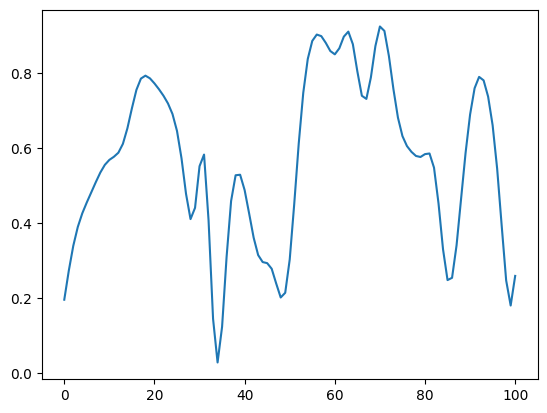

In [73]:
# plt.plot(QBER[:1000,0])

# DOWNSAMPLE
QBER_downsampled = QBER[::100]
plt.plot(QBER_downsampled[:1000,0])

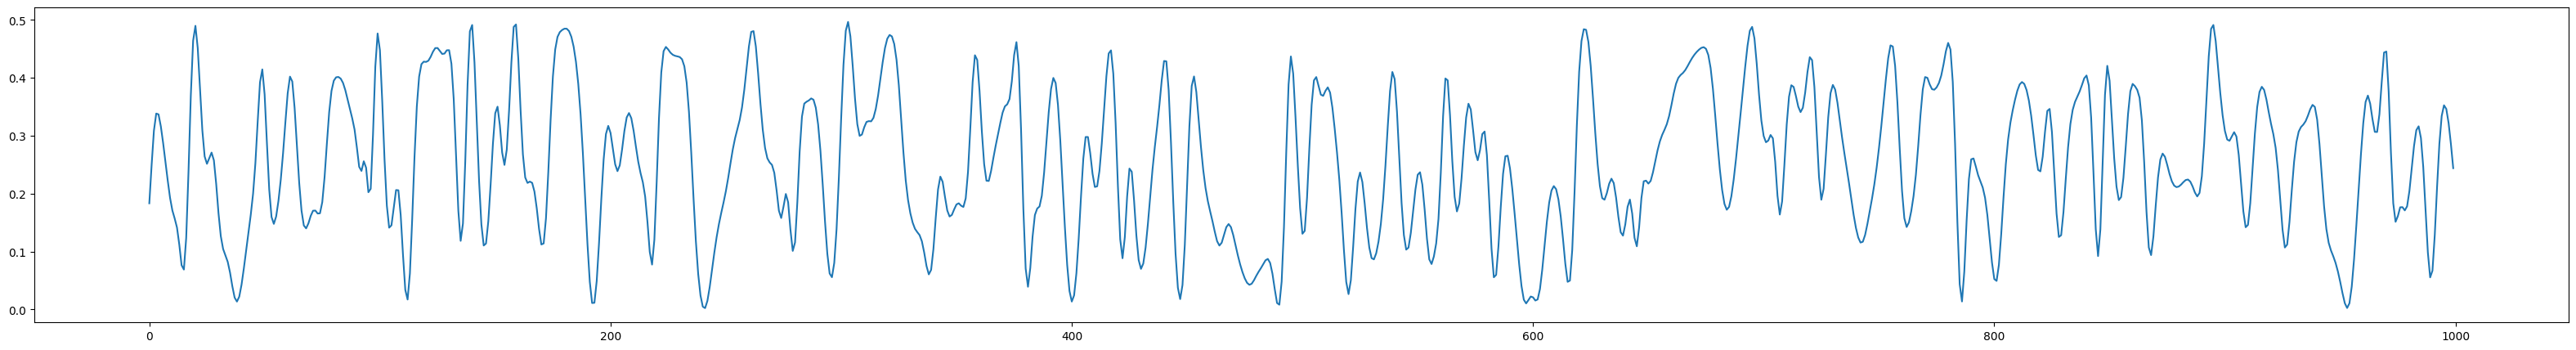

In [2]:
QBER = np.load('data/QBER.npy')

QBER_downsampled_large = QBER[::100]
plt.figure(figsize=(40,5))
plt.plot(QBER_downsampled_large[:1000,0])

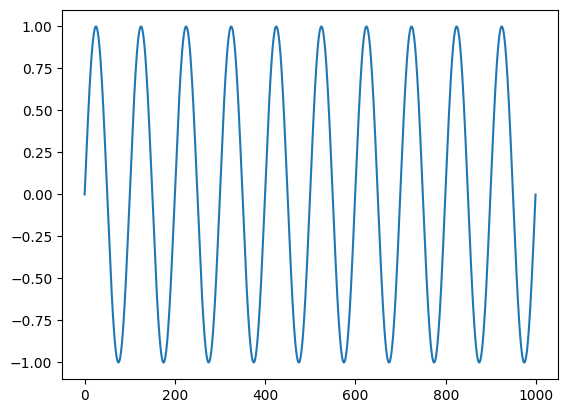

In [74]:
input = np.sin(np.linspace(0, 20*np.pi, 1000))
plt.plot(input)

In [7]:
# plt.plot(QBER[:,0],label='QBERz')
# plt.plot(QBER[:,1],label='QBERx')
# plt.legend(loc = 'upper right')
# plt.ylabel('QBER')
# plt.xlabel(f'Time Step {env.delta_t}s')
# plt.show()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

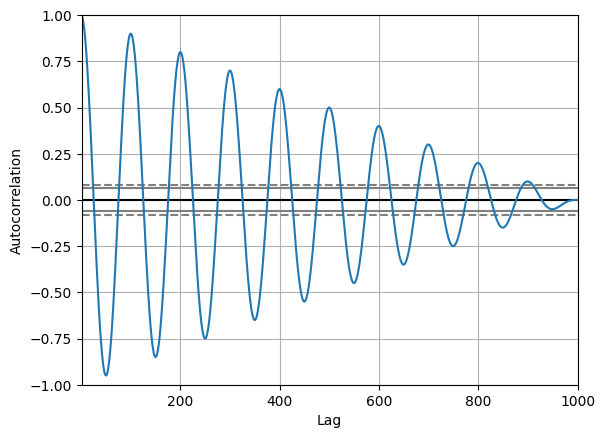

In [11]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(input)

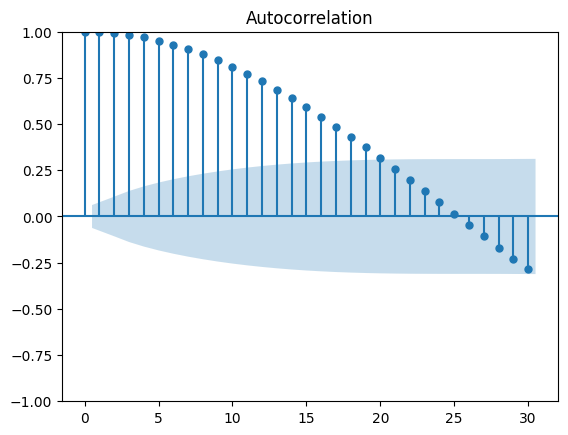

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(input)
plt.show()

In [10]:
# import pmdarima as pmd

# model=pmd.auto_arima(QBER[:100000,0],start_p=1,start_q=1,test='adf',seasonal=True,trace=True)

In [13]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(input, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)
# p-value <= significance level (0.01, 0.05, 0.10, etc.)
# If the p-value is greater than the significance level then
# we can say that it is likely that the data is not stationary.

Results of Dickey Fuller Test:
Test Statistic                -2.666192e+13
p-value                        0.000000e+00
#Lags Used                     1.000000e+00
Number of Observations Used    9.980000e+02
Critical Value (1%)           -3.436919e+00
Critical Value (5%)           -2.864440e+00
Critical Value (10%)          -2.568314e+00
dtype: float64


p-value > 0.05 => Data is not stationary

In [14]:
import pmdarima as pmd

#Standard ARIMA Model
ARIMA_model = pmd.auto_arima(input, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

/usr/local/lib/python3.8/dist-packages/statsmodels/regression/linear_model.py:1884: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


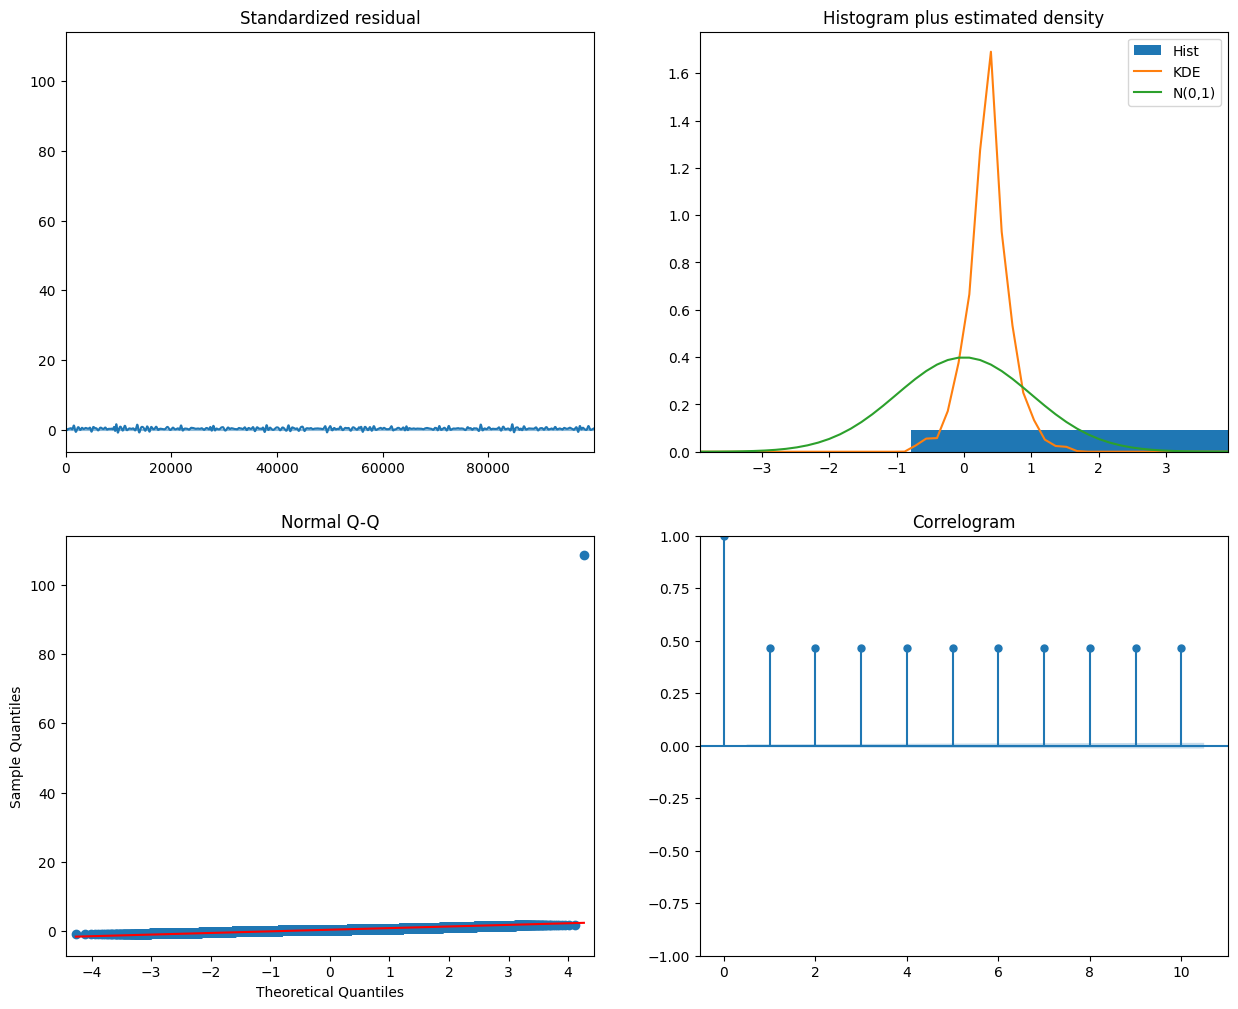

In [13]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

### Standardized residual

There are no obvious patterns in the residuals, with values having a mean of zero and having a uniform variance.

### Histogram plus KDE estimate

The KDE curve should be very similar to the normal distribution (labeled as N(0,1) in the plot)

### Normal Q-Q

Most of the data points should lie on the straight line

### Correlogram (ACF plot)

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, all values outside of this area, and therefore we need to add more predictors to make the model more accurate

As we can see from the plot below, this doesn’t seem to be a very accurate forecast. Maybe we need to change the model structure so that it takes into account seasonality?

SARIMA model so that we can account for seasonality.

# Analysis?

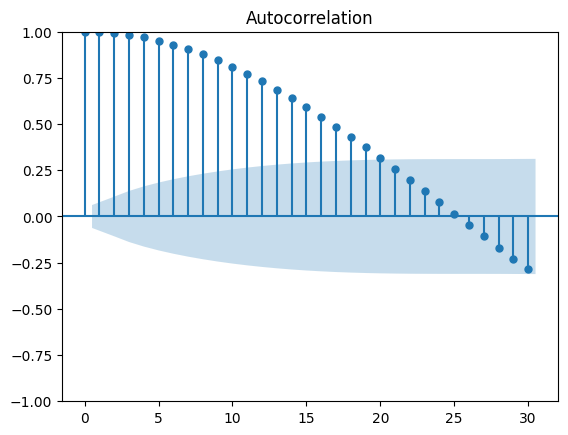

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(input)
plt.show()

In [57]:
from statsmodels.tsa.arima.model import ARIMA

ARIMA_model = ARIMA(input, order=(1, 2, 2))

model = ARIMA_model.fit()

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 2, 2)   Log Likelihood                4335.586
Date:                Mon, 13 May 2024   AIC                          -8663.172
Time:                        11:52:37   BIC                          -8643.549
Sample:                             0   HQIC                         -8655.714
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       7.957e-08      0.764   1.04e-07      1.000      -1.497       1.497
ma.L1       7.957e-08      0.764   1.04e-07      1.000      -1.497       1.497
ma.L2       7.878e-08      1.533   5.14e-08      1.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


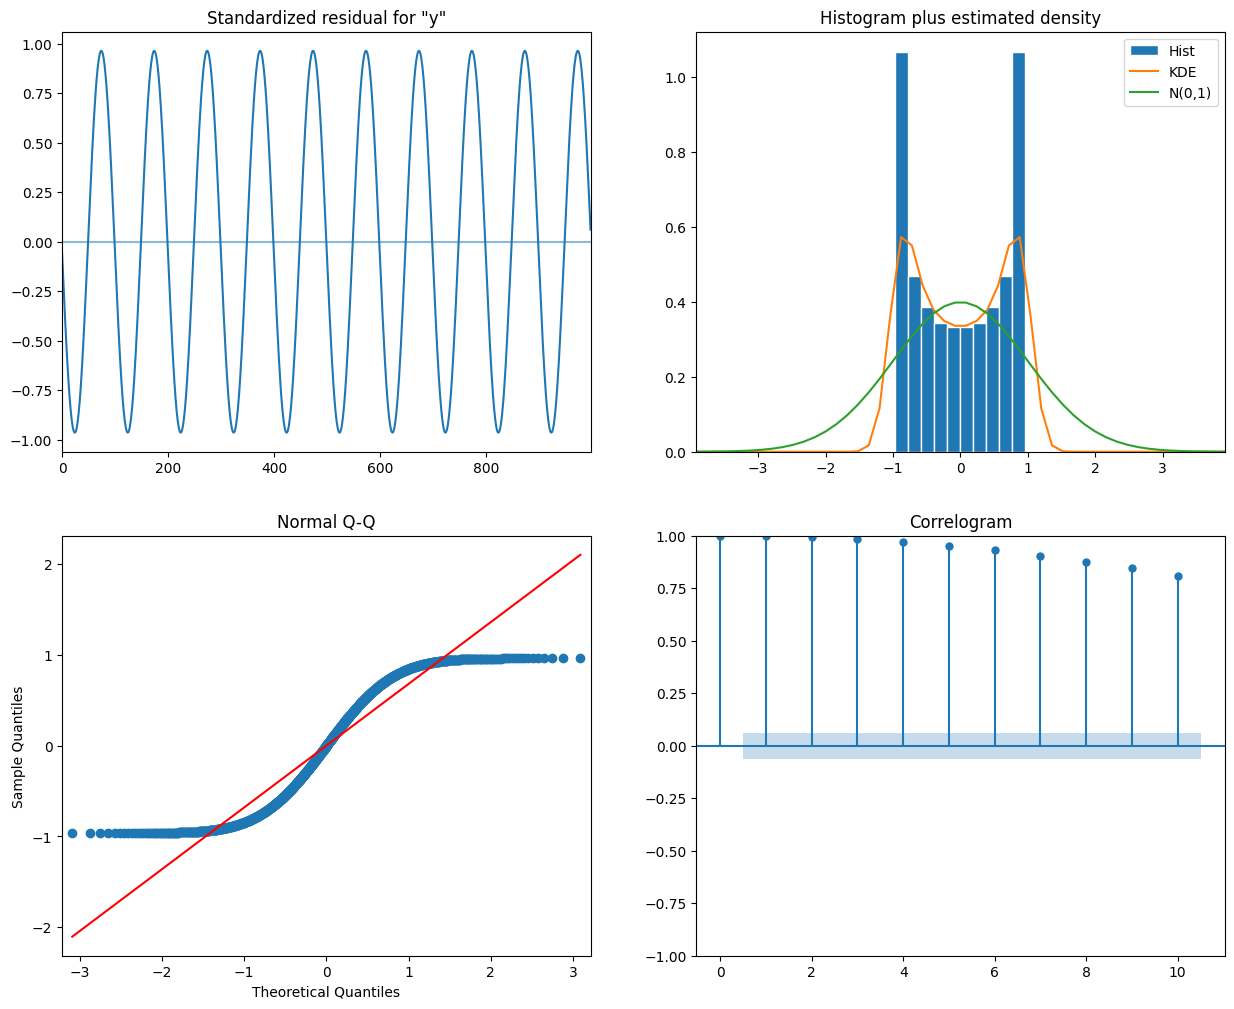

In [48]:
model.plot_diagnostics(figsize=(15,12))
plt.show()

In [3]:
# Import statsmodels library
import statsmodels.api as sm

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(input, 
                                          model='additive', 
                                          period=12)

# Extract the decomposed components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the decomposed components
decomposition.plot()
plt.show()

TypeError: float() argument must be a string or a number, not 'method'

# Grid search

In [58]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

ARIMA(0, 0, 0) RMSE=0.717
Best ARIMA(0, 0, 0) RMSE=0.717
ARIMA(0, 0, 1) RMSE=0.359
Best ARIMA(0, 0, 1) RMSE=0.359
ARIMA(0, 1, 0) RMSE=0.044
Best ARIMA(0, 1, 0) RMSE=0.044
ARIMA(0, 1, 1) RMSE=0.022
Best ARIMA(0, 1, 1) RMSE=0.022
ARIMA(0, 1, 2) RMSE=0.011
Best ARIMA(0, 1, 2) RMSE=0.011
ARIMA(0, 2, 0) RMSE=0.003
Best ARIMA(0, 2, 0) RMSE=0.003
ARIMA(0, 2, 1) RMSE=0.003
Best ARIMA(0, 2, 1) RMSE=0.003
ARIMA(0, 2, 2) RMSE=0.002
Best ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 0, 0) RMSE=0.044
Best ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 0, 1) RMSE=0.022
Best ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 0, 2) RMSE=0.011
Best ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 1, 0) RMSE=0.003
Best ARIMA(0, 2, 2) RMSE=0.002
ARIMA(1, 1, 1) RMSE=0.001
Best ARIMA(1, 1, 1) RMSE=0.001
ARIMA(2, 0, 0) RMSE=0.002
Best ARIMA(1, 1, 1) RMSE=0.001
ARIMA(2, 0, 1) RMSE=0.004
Best ARIMA(1, 1, 1) RMSE=0.001
ARIMA(2, 0, 2) RMSE=0.015
Best ARIMA(1, 1, 1) RMSE=0.001
ARIMA(4, 0, 0) RMSE=0.001
Best ARIMA(4, 0, 0) RMSE=0.001
ARIMA(4, 0, 1) RMSE=0.000
Best 

In [ ]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
 
# load dataset
# def parser(x):
#     return datetime.strptime('190'+x, '%Y-%m')
# series = read_csv('shampoo-sales.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(input, p_values, d_values, q_values)


In [6]:
from tqdm import tqdm
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

In [87]:
X = input
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (4,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

100%|██████████| 340/340 [04:42<00:00,  1.20it/s]


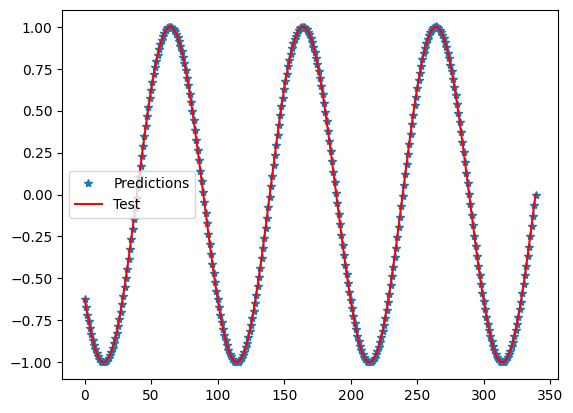

In [88]:
plt.plot(predictions, '*')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

# Downsampled QBER 1k

In [89]:
X = QBER_downsampled_large[:1000,0]
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (4,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

100%|██████████| 340/340 [01:04<00:00,  5.23it/s]


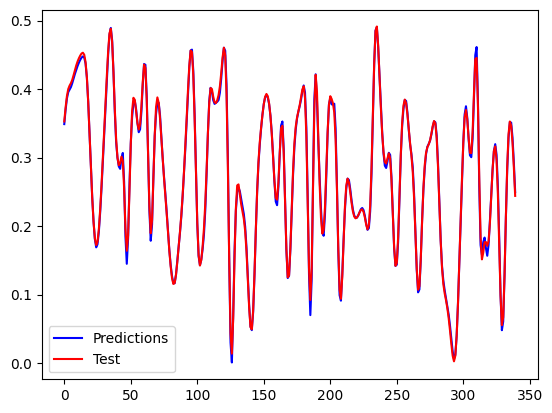

In [90]:
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])

# Downsampled QBER 100k

In [7]:
X = QBER_downsampled_large[:,0]
# prepare training dataset
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()
for t in tqdm(range(len(test))):
    model = ARIMA(history, order= (4,0,0))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
# calculate out of sample error
rmse = sqrt(mean_squared_error(test, predictions))

100%|██████████| 3400/3400 [34:35<00:00,  1.64it/s]


NameError: name 'sqrt' is not defined

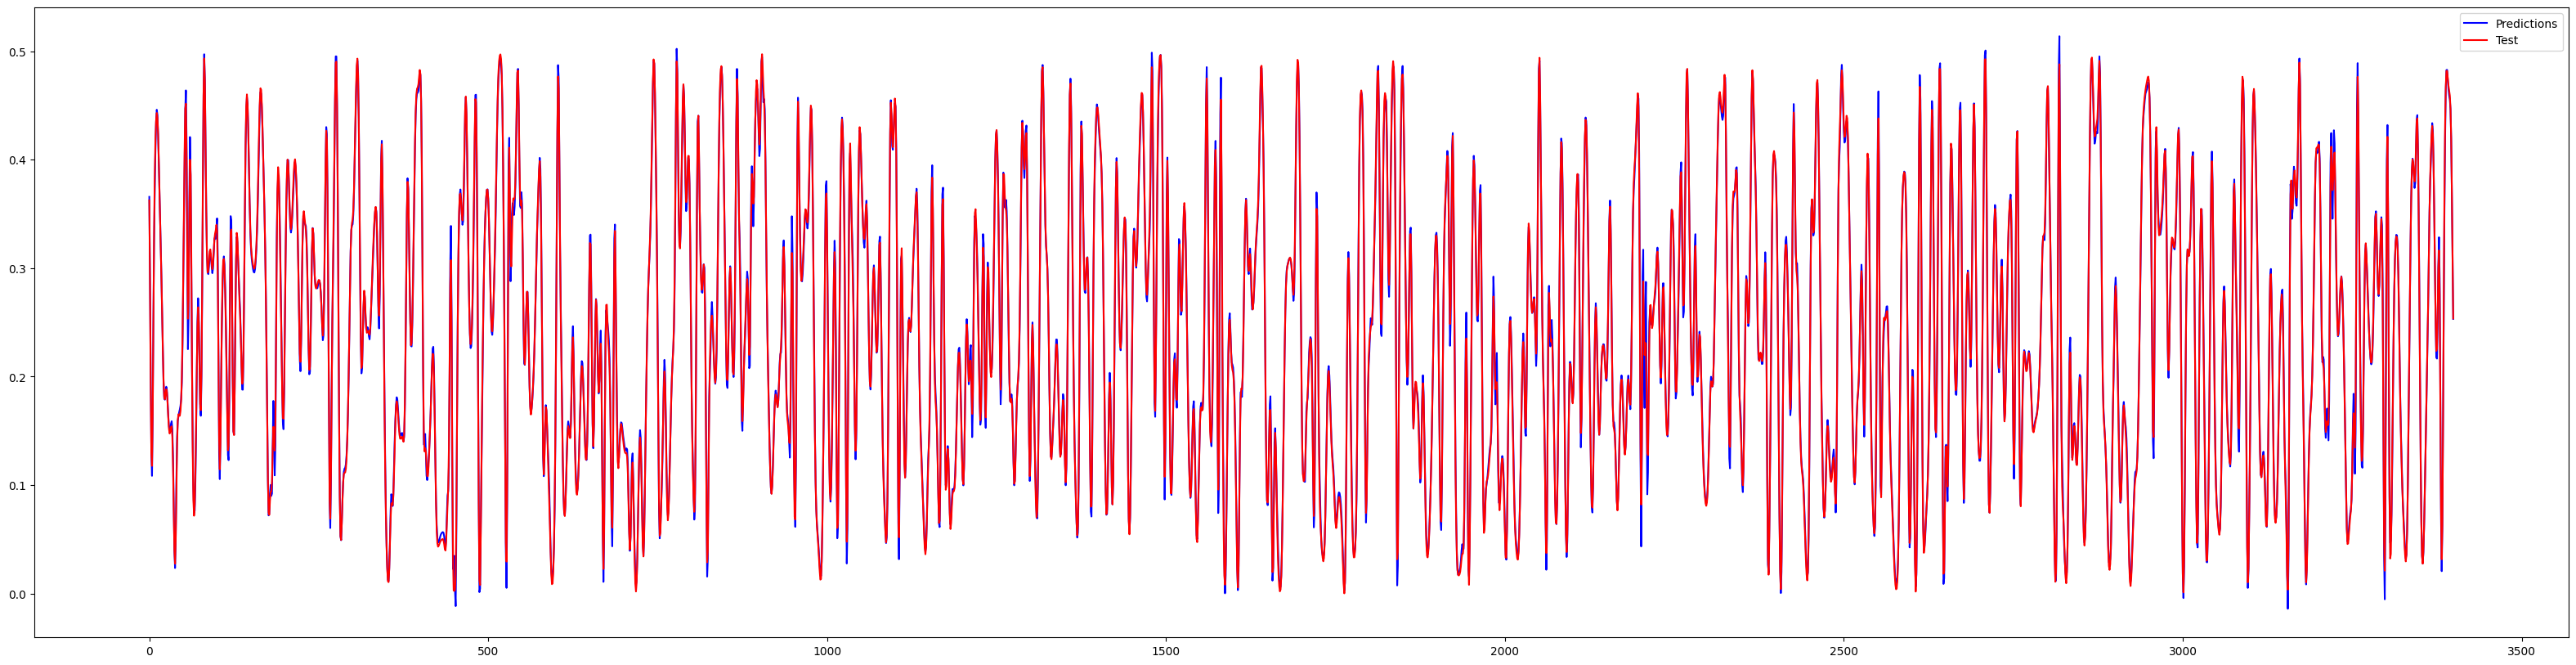

In [10]:
plt.figure(figsize=(40,10))
plt.plot(predictions, 'b')
plt.plot(test, 'r')
plt.legend(['Predictions', 'Test'])